# Time Series Anaysis

A time series is simply a series of observations of a random variable $X$ depending on time $t$ ($X_t$) over a set of subsequent moments of time $t=1,...,T$ (or $t=1,2,...$ for $T=\infty$):
$$
\{x_t, t=1,...,T\}.
$$
Examples include daily (or hourly or 15/5/1 min) stock prices, weather observations, noise level on the street changing over time, daily/hourly traffic counts, taxi ridership etc.


We assume that there is a certain consistent Data Generating Process behind those observations.
A set of random variables $X_t$ generating a time-series observations is called a stochastic process.

Time increments could be a month, a day, an hour, minute, second, or something smaller.

Typically unless specified otherwise, assume that variables $X_t$ and their observations $x_t$ are real-valued and one-dimentional, however discrete or multidimensional values are also considered in general. 

Goals of time-series analsys are mainly twofold:

#### pattern recognition
(signal detection, financial trends, weekly activity patterns, anomaly detection etc)

#### predictive modelling
(stock prices prediction, weather forecast etc)

Sometimes time-series could be also used for classification purposes, classifying the objects based on temporal variation of a certain parameter, like classification of land use of certain territories based on timeline of human activity there, sound classification etc

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

#from IPython.display import Image

import seaborn as sns
sns.set()

%matplotlib inline


### Key Topics in Time Series Analysis

#### 1. Trend and seasonality detection
are there consistent upward or downward patterns in the time-series (trends)? Does the time-series demonstrate periodic behavior with seasonal variations? what are the properties of the residual time-series after all recognizeable temporal patterns are removed? 
#### 2. Hypothesis testing
prove significance of the hypothesized patterns behind observed time-series. E.g. is the detected trend statistically significant?
#### 3. Forecasting through predictive modeling
Can we predict the future observations? Are there significant correlations between time-adjacent observations? can we model those?
#### 4. Simulation modeling
based on our knowledge of the time-series patterns and process behind them, estimate probability of certain outcomes through multiple simulations of the process.
#### 5. Control
how can we impact the time-series in order to reach the certain objectives through certain actions that we're in control of? E.g. how to make sure time-series will remain stable over time?

In [2]:
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()

start, end = "1992-02-01", "2022-02-01"
tbond10 = pdr.get_data_yahoo("^TNX", start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
tbond10.tail()

Date
2022-01-25 00:00:00-05:00    1.783
2022-01-26 00:00:00-05:00    1.848
2022-01-27 00:00:00-05:00    1.807
2022-01-28 00:00:00-05:00    1.782
2022-01-31 00:00:00-05:00    1.782
Name: Adj Close, dtype: float64

Text(0, 0.5, '%')

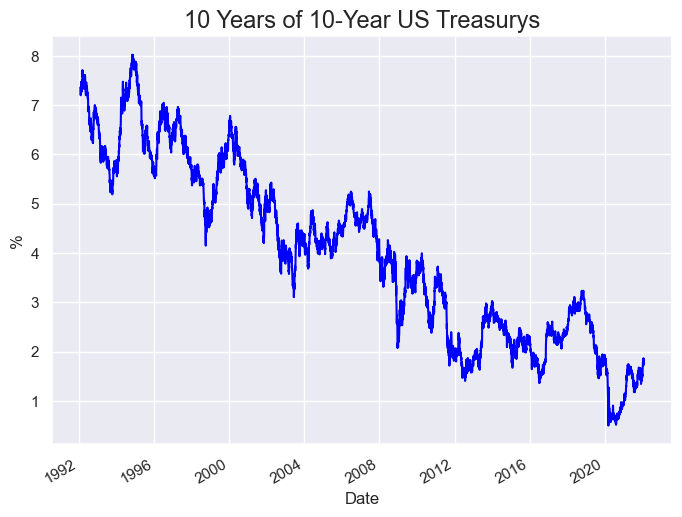

In [4]:
tbond10.plot(color='blue', figsize=(8, 6))
plt.title('10 Years of 10-Year US Treasurys', fontsize=17)
plt.ylabel('%')

In [5]:
dfbond10=pd.DataFrame(tbond10)
dfbond10.head()

,Adj Close
Date,
1992-02-03 00:00:00-05:00,7.36
1992-02-04 00:00:00-05:00,7.29
1992-02-05 00:00:00-05:00,7.21
1992-02-06 00:00:00-05:00,7.20
1992-02-07 00:00:00-05:00,7.20


### Questions of time-series analysis:

1. is there a trend?

2. is there a period/seasonality?

3. what is not explained by trend/seasonality? what does the "noise" look like? what are the anomalies?

4. can we predict future values?

In [6]:
#ways to assess the trend

In [7]:
#difference in the end and beginning divided by time period
(tbond10.loc['2022-01-03']-tbond10.loc['1992-02-03'])/30


-0.19106667041778563

In [8]:
#depends on the begining and end point choice
(tbond10.loc['2021-03-02']-tbond10.loc['1992-03-02'])/29

-0.2056896604340652

In [9]:
#regression over time
lm=sm.OLS(dfbond10['Adj Close'],sm.add_constant(dfbond10.index.year)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 5.377e+04
Date:                Mon, 13 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:03:33   Log-Likelihood:                -7296.6
No. Observations:                7531   AIC:                         1.460e+04
Df Residuals:                    7529   BIC:                         1.461e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        398.8669      1.703    234.242      0.0

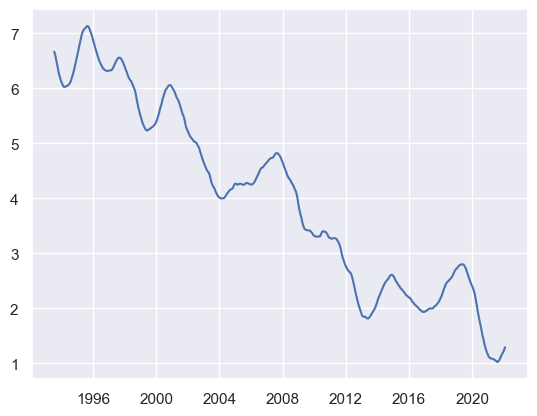

In [10]:
#smoothen the time-series
#one year moving average (avg values over the last year preceding the oversation)
plt.plot(tbond10.rolling(window = 365).mean());

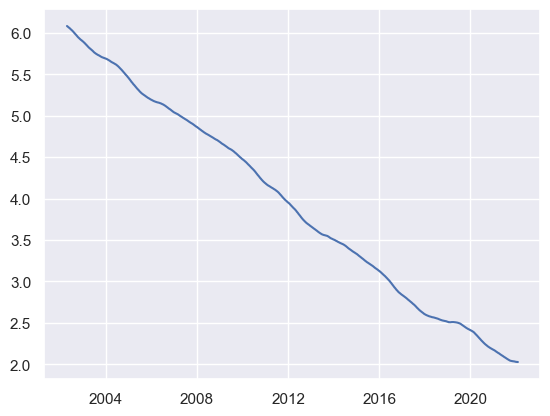

In [11]:
#smoothen the time-series
#7 year moving average (avg values over the last 7 years preceding the oversation)
plt.plot(tbond10.rolling(window = 7*365).mean());

## Trend-Seasonality-Noise decomposition

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

**Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled.

**Non-Systematic**: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

A time series is thought to be an aggregate or combination of these four components.
(All series have a level and noise. The trend and seasonality components are optional.)

It is helpful to think of trend and seasonality as either **additive** or **multiplicative** components of the model representing the trend data $\{x_t, t=1,...,T\}$.

- Additive Model
An additive model suggests that the components are added together as follows:

$ x_t = ConstLevel + Trend_t + Seasonality_t + Noise_t $

An additive model assumes consistent additive changes over time. The trend could be linear (constant increase or decrease over time) or nonlinear.
Seasonality is a periodic (cyclic) time-series ($Seasonality_{t+d} = Seasonality_t$) with a certain period $d$ (width of the cycles), frequency $1/d$ (inverse width of the cycles) and amplitude (height of cycles).

- Multiplicative Model
A multiplicative model suggests that the components are multiplied together as follows:

$ x_t = ConstLevel * Trend_t * Seasonality_t * Noise_t $

A multiplicative model is nonlinear, e.g. exponential where values scale by a constant factor over time. 
A multiplicative seasonality represents scaling of values repeated over time. The multiplicative model could be explored using the same means as the additive model by simply considering the logarithm of the trend:

$ log(x_t) = log(Level) + log(Trend) + log(Seasonality) + log(Noise) $

More precisely, a trend-seasonality modeling of a time-series $\{x_t, t=1,...,T\}$ implies findind underlying random variables $X_t$ generating the values $x_t$ as 
$$
X_t=m_t+s_t+Y_t,
$$
where $m_t$ is the deterministic function of $t$, responsible for systematic change of $X$ over time (trend component), $s_t$ is a periodic function of $t$ (seasonal component) with a known period $d$, such that $s_{t+d}=s_t$ and $\sum_{j=0}^{d-1}s_{t+j}=0$ (otherwise non-zero shift should be included as part of the trend), and residual values are modeled by random variables $Y_t$ free of any trend or periodicity, having the same zero averages over time $E[Y_t]=0$ (otherwise non-zero averages should be accounted for by $m_t$ and/or $s_t$).

The trend $m$ could be a linear or non-linear increasing or decreasing function of time $t$.

Often $s$ represents an annual, weekly or daily variation. Of course not any given time-series have clear seasonal components but looking for such representation is the goal of basic time-series exploratory analysis.

More generally $s_t$ could be a sum of several periodic functions $s_t=\sum_k s^k_t$ with different periods $d^k$. This allows to account for an overlapping combination of different seasonal variations, such as weekly and daily ones together.

If seasonality period $d$ is known then moving average smoothing $m_t = \frac{\sum_{j=0}^{\tau-1} x_{t-j}}{\tau}$ with the lag $\tau = kd$ being a factor of $d$ eliminates seasonal component $s_t$ also reducing the relative impact of the residuals (as the variance of an average of $n$ residuals decrease proportionally to $n$) - this was the trend component $m_t$ could be estimated. 

Then once the trend component is removed ($X_t-m_t$) one can focus on estimating $s_\tau, \tau=0..d$ as sample means of the corresponding available observations at $t, t\pm d, t\pm 2d,...$ after trend subtraction
$$
s_t=\frac{\sum\limits_k \left(x_{k d+t}-m_{k d+t}\right)}{|\{k\}|},
$$
since $E[Y_t]=0$.

But what if we do not have a good idea of what the periods could be? Spectral decomposition though Fourier transform technique could help with that. We won't focus too much on the theory and computational approach here.
Python has ready to use tools of estimating this decomposition given the time-series observations (Fast Fourier Transform) as well as estimating the relative strength of different possible periods $d_k$ (periodigram) allowing to pick up the one or several ones, most consistent with the observations. We'll illustrate this below.

## CO2 emissions data case

In [12]:
# acquire the data - a standard statsmodels dataset

#emissions = pd.read_csv('co2_weekly.csv')
#emissions = emissions[['year','month','day','average']]
#emissions.rename(columns={'average':'co2'},inplace=True)
#emissions.to_csv('co2_daily_by_week.csv', index=False)

emissions = pd.read_csv('co2_daily_by_week.csv')
emissions['date'] = pd.to_datetime(emissions[['year', 'month', 'day']])
emissions.drop(['year', 'month', 'day'],axis=1,inplace=True)
emissions.set_index('date',inplace=True)
emissions['co2'].loc[emissions['co2'] < -900] = np.nan
emissions['co2'].interpolate(inplace=True)
emissions.tail()

,co2
date,
2021-11-28,416.16
2021-12-05,415.86
2021-12-12,416.45
2021-12-19,417.49
2021-12-26,417.46


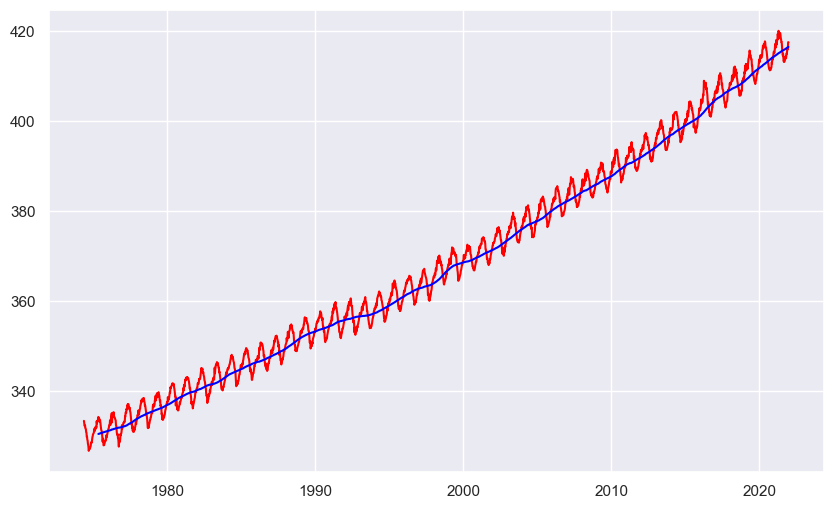

In [13]:
#plot the data along with the one year moving average
plt.figure(figsize = (10,6))
plt.plot(emissions.index,emissions.co2, label = 'co2', color = 'red')
plt.plot(emissions.index,emissions.co2.rolling(window = 52).mean(), label = 'co2', color = 'blue');

Decompose the data into the trend, repeated (seasonal) component over 52 week (approx 1 year) period and the residual fluctuations

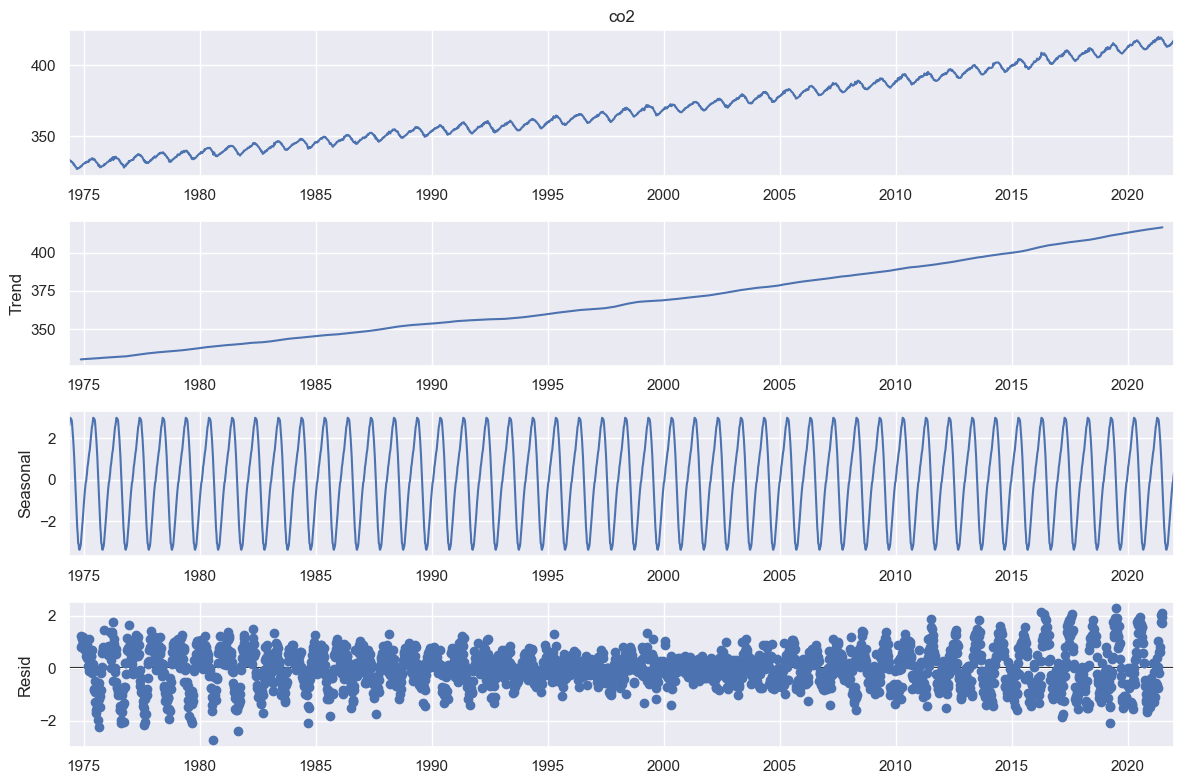

In [14]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
res = sm.tsa.seasonal_decompose(emissions.co2,model='additive',period=52)
res.plot()
plt.show()

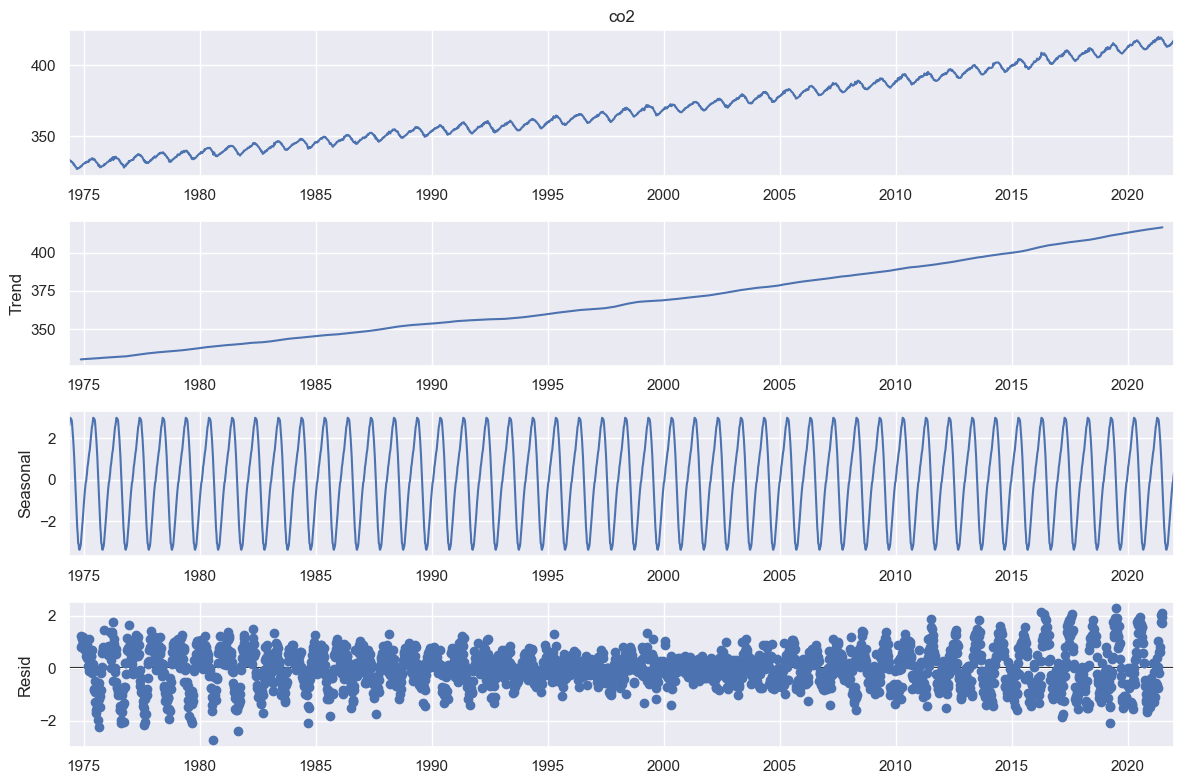

In [15]:
#version of the decomposition with the multiplicative seasonal and residual factors
matplotlib.rcParams['figure.figsize'] = [12, 8]
res = sm.tsa.seasonal_decompose(emissions.co2,model='additive',period=52)
res.plot()
plt.show()

What if we do not know the period? A periodigram shows the strength of each period measured as Power Spectral Density (see https://en.wikipedia.org/wiki/Spectral_density and https://www.probabilitycourse.com/chapter10/10_2_1_power_spectral_density.php for details; the definition involves Fourier Transform) for each period frequency - number of periods per unit of time. The higher is the PSD value the stronger is the period

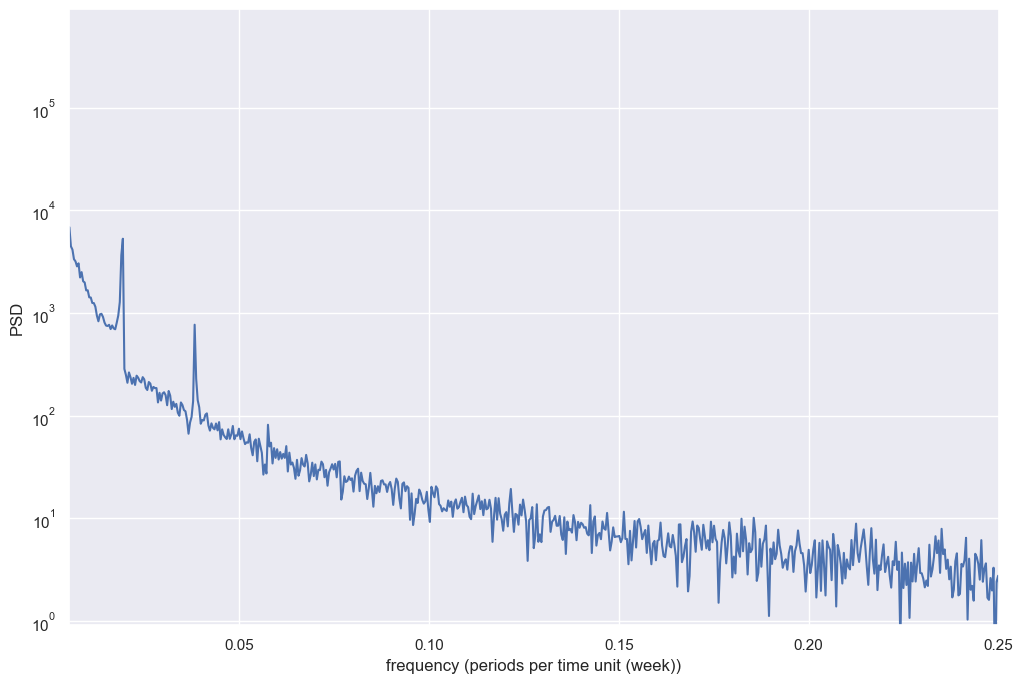

Strongest period length = 51.770833333333336


In [16]:
f, PSD = scipy.signal.periodogram(emissions.co2)
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit (week))')
plt.ylabel('PSD')
plt.xlim(0.005,0.25) #show frequencies within 1/4..1/200, periods of 4-200 weeks
plt.ylim(max(PSD)/1e6,max(PSD)) #show strength up to 1e-6 of the max

#filter outputs - periods shorter than 2 years (approx 100 weeks) 
PSD = PSD[f>0.01]
f = f[f>0.01] 
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period

#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

Alternatively one can consider autocorrelations: $A(\tau) = corr(x(t), x(t-\tau))$ - correlations between the values of the time-series as the present moment and the values over $\tau$ (lag) units of time ago. The $A(\tau)$ typically decline with $\tau$ (as the strogest correlation is observed with the most recent values) however the values over an integer number of period ago demonstrate stronger correlations. So the lags $\tau = period, 2*period, 3*period...$ will show local peaks of the autocorrelation.

<Figure size 800x800 with 0 Axes>

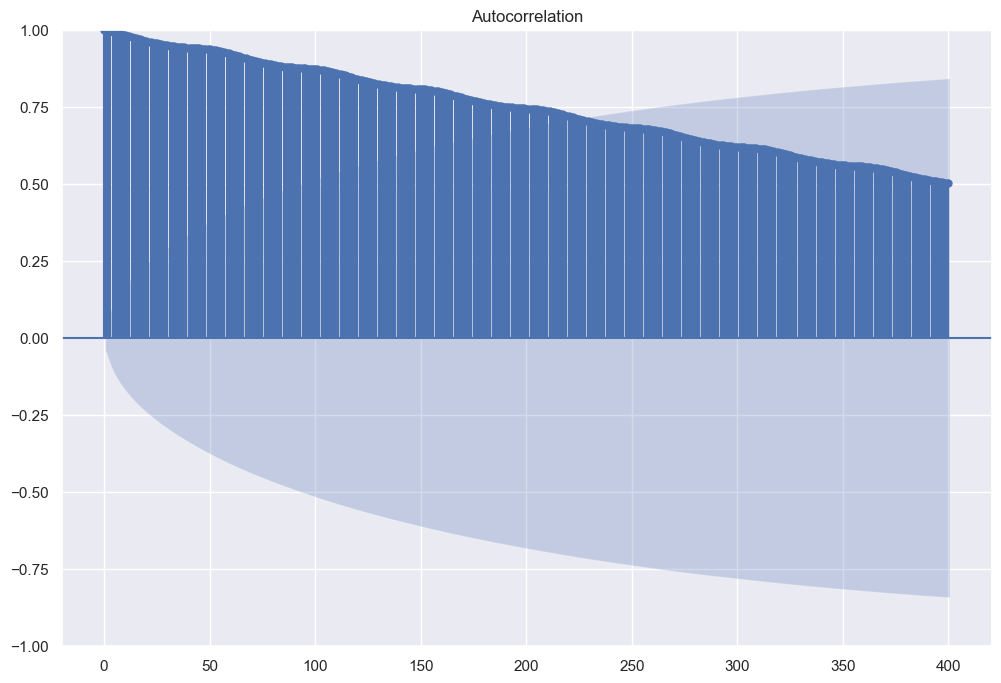

In [17]:
plt.figure(figsize = (8,8))
plot_acf(emissions.co2, lags = 400)
plt.show()

#plot autocorrelations for lags up to 400 weeks
#we see spikes around 52 (1 year), 104 (2 years), ... highlighting an annual period

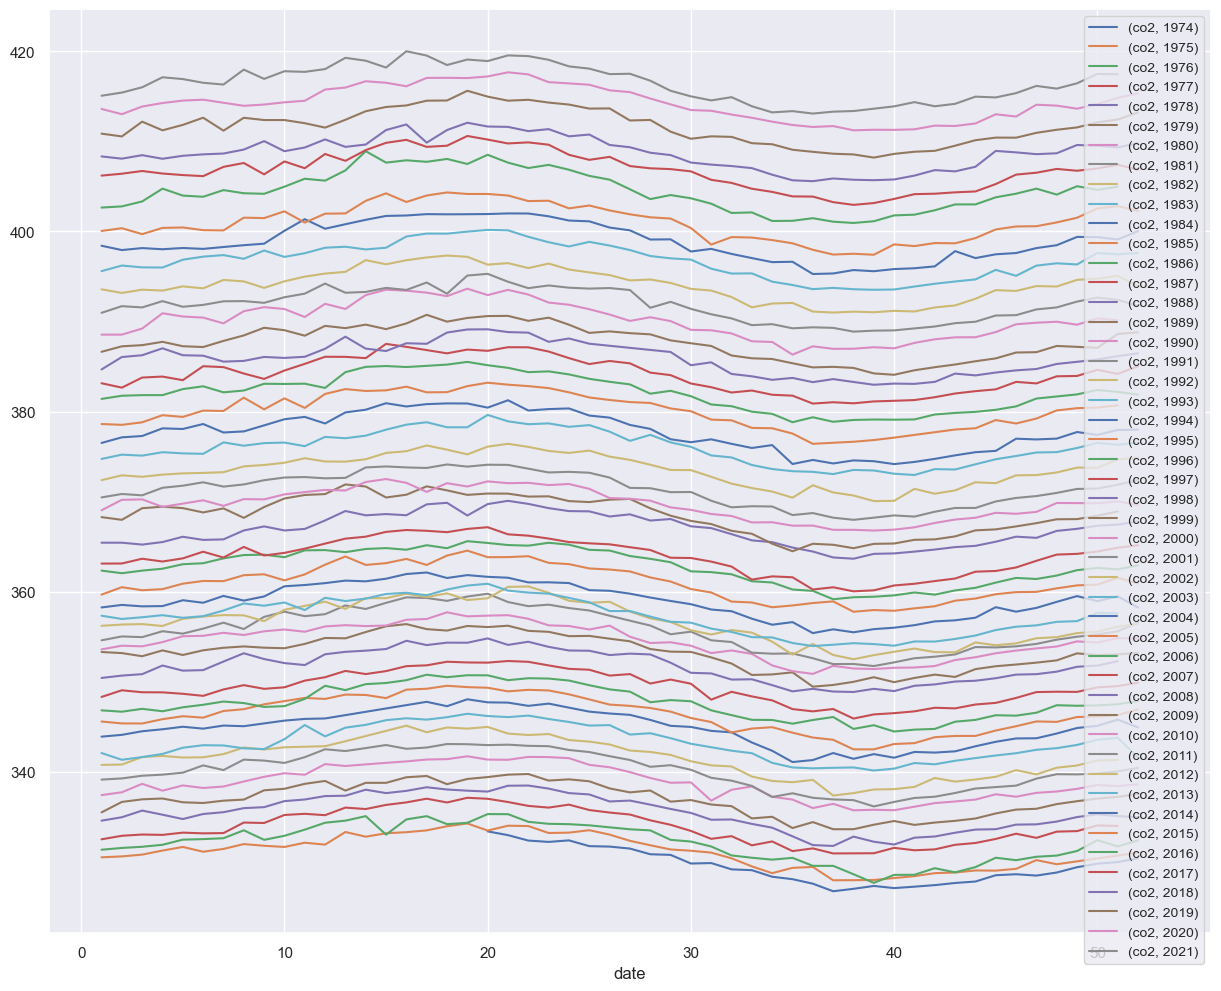

In [18]:
# let's also stack it by year

data_to_plot = pd.pivot_table(data=emissions, index = emissions.index.week, columns = emissions.index.year)
#data_to_plot
fig = plt.figure(figsize = (15, 12))
data_to_plot.plot(ax = fig.add_subplot(111))
plt.legend(loc=1, fontsize = 'small')
plt.show()

# Urban case: FHV ridership near PENN Station

## 1. Visualization of Daily Traffic Counts 
Upload and visualize the total number of yellow and green taxies per day over 3 years 2018,2019,2020

In [19]:
hourlyData = pd.read_csv('https://raw.githubusercontent.com/CUSP2022ADS/Data/main/3yearsYellowGreen.csv') #hourly trip count
hourlyData['time'] = pd.to_datetime(hourlyData['time'])

# extract date from time
hourlyData['date'] = hourlyData['time'].dt.date

# aggregate hourly dataset to daily dataset
dailyData = hourlyData.groupby(['date']).agg({'yellow':'sum','green':'sum'}).reset_index()
dailyData.head()

,date,yellow,green
0,2018-01-01,237145.0,23361.0
1,2018-01-02,238152.0,23226.0
2,2018-01-03,266992.0,26418.0
3,2018-01-04,122222.0,6523.0
4,2018-01-05,265212.0,27459.0


In [20]:
# get the number of samples
nsamp = len(dailyData)

# convert the `date` feature into `dt.datetime` format. This is for later datetime operations
Time = dailyData['date'].values

# print dataset characteristics
print('This is the original dataset characteristics:')
timeperiod = Time[-1] - Time[0] + pd.to_timedelta(1,unit='day')

# this is the duration of our observations: tail - head + 1 
print('The time period for this dataset is: ', timeperiod.days)
print('The number of observations are: ', nsamp)
print(dailyData.describe())

This is the original dataset characteristics:
The time period for this dataset is:  912
The number of observations are:  912
              yellow         green
count     912.000000    912.000000
mean   223738.191886  17627.921053
std     87857.827821   7534.726634
min      4434.000000    608.000000
25%    203884.750000  14495.000000
50%    244389.500000  17593.500000
75%    279857.750000  23201.000000
max    349840.000000  33953.000000


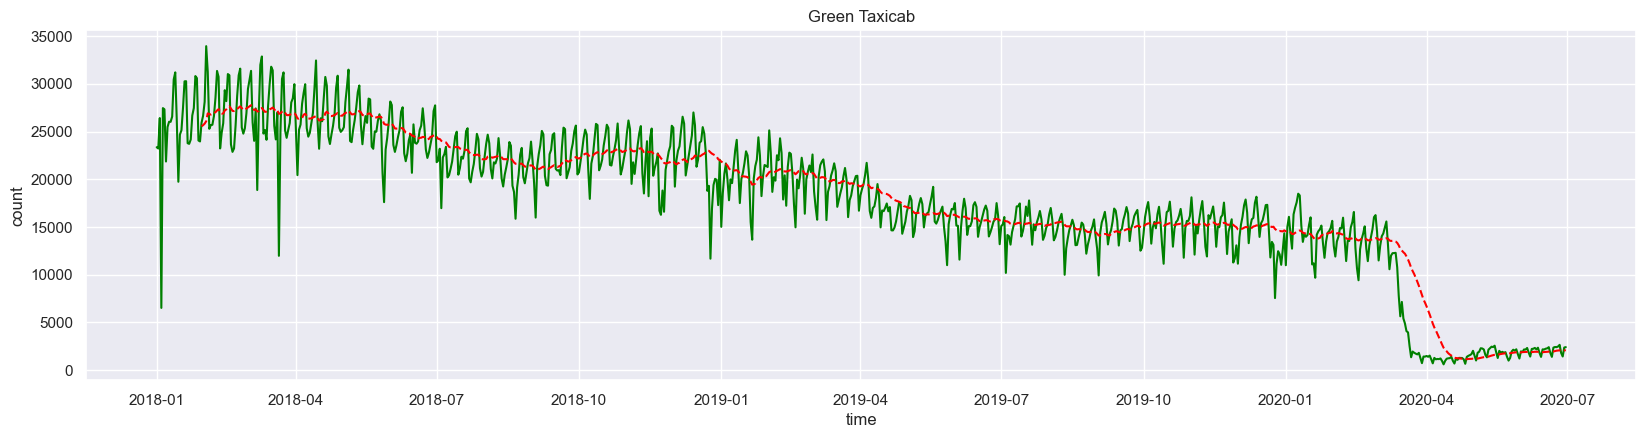

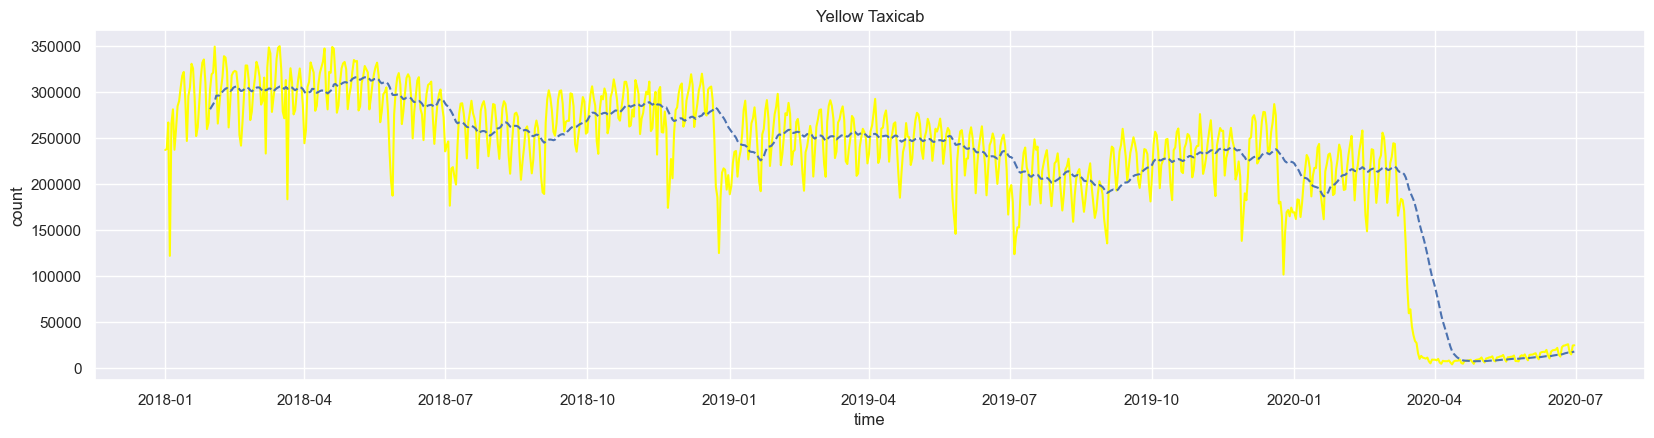

In [21]:
# plot the daily `green` and `yellow` taxi ridership on the timeline
# the '--' line is 30-day moving average

xTime = dailyData['date']
yGreen = dailyData['green']
yYellow = dailyData['yellow']
plt.figure(figsize = (20,10))
plt.subplot(211)
plt.title('Green Taxicab')
plt.xlabel('time')
plt.ylabel('count')
FHV_ata_line = plt.plot(xTime,yGreen, label = 'Green', color = 'green')
FHV_mean_line = plt.plot(xTime,yGreen.rolling(window = 30).mean(), label='Green Mean', linestyle='--',color='red')

plt.figure(figsize = (20,10))
plt.subplot(212)
plt.title('Yellow Taxicab')
plt.xlabel('time')
plt.ylabel('count')
yellow_data_line = plt.plot(xTime,yYellow, label = 'Yellow Taxicab', color = 'yellow')
yellow_mean_line = plt.plot(xTime,yYellow.rolling(window = 30).mean(), label='Yellow Mean', linestyle='--')
plt.show()

Clearly the year 2020 looks quite particular, demonstrating a significant ridership drop in the second quarter of 2020. The obvious reason for that is the COVID-19 pandemics lockdown, which started in March, 2020. Below we use time-series analysis to model the ridership in 2018-2019 and apply the model to 2020 in order to see how different is the observed pattern from what one would expect under normal conditions.

## 2. Trend and seasonality
### Q1. Use a linear regression model to establish trends in green taxi ridership in 2018 and 2019
Build a regression of the daily ridership counts vs the number of days since Jan, 1, 2018. Which statistics highlight the significance of the trend?

In [22]:
lm=sm.OLS(dailyData.green[:730],sm.add_constant(dailyData.index[:730])).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  green   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     1866.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          4.58e-203
Time:                        15:03:55   Log-Likelihood:                -6787.0
No. Observations:                 730   AIC:                         1.358e+04
Df Residuals:                     728   BIC:                         1.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.765e+04    195.437    141.492      0.0

The slope coefficient characterizes the trend. Its p-value quantifies the trend significance

### Q2. Find a proper period in the green taxi in 2018 and 2019
Try 7(week), 30(month) periods

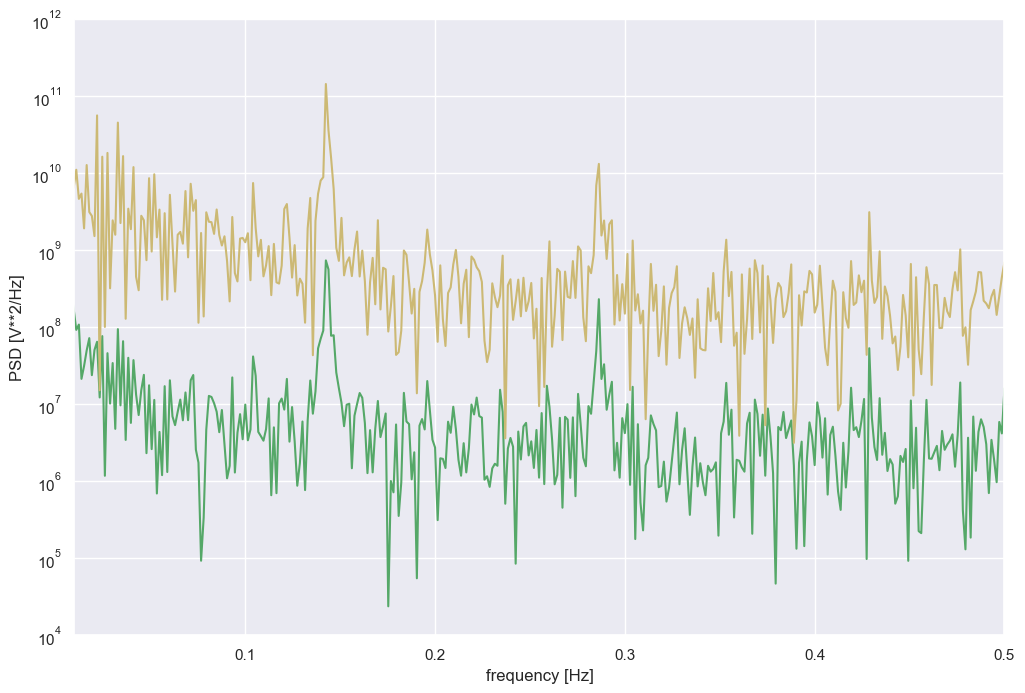

Strongest period yellow = 7.019230769230769
Strongest period green = 7.019230769230769


In [23]:
#find possible periods if we're not sure which one to take

f, PSD = scipy.signal.periodogram(dailyData.green[:730])
f2, PSD2 = scipy.signal.periodogram(dailyData.yellow[:730])
plt.semilogy(f, PSD, 'g')
plt.semilogy(f2, PSD2, 'y')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0.01,0.5) #period from 2 to 100 days
plt.ylim(1e4,1e12)
plt.show()
PSD = PSD[f>0.01]; f = f[f>0.01]
PSD2 = PSD2[f2>0.01]; f2 = f2[f2>0.01]
print('Strongest period yellow = {}'.format(1/f2[np.argmax(PSD2)]))
print('Strongest period green = {}'.format(1/f[np.argmax(PSD)]))

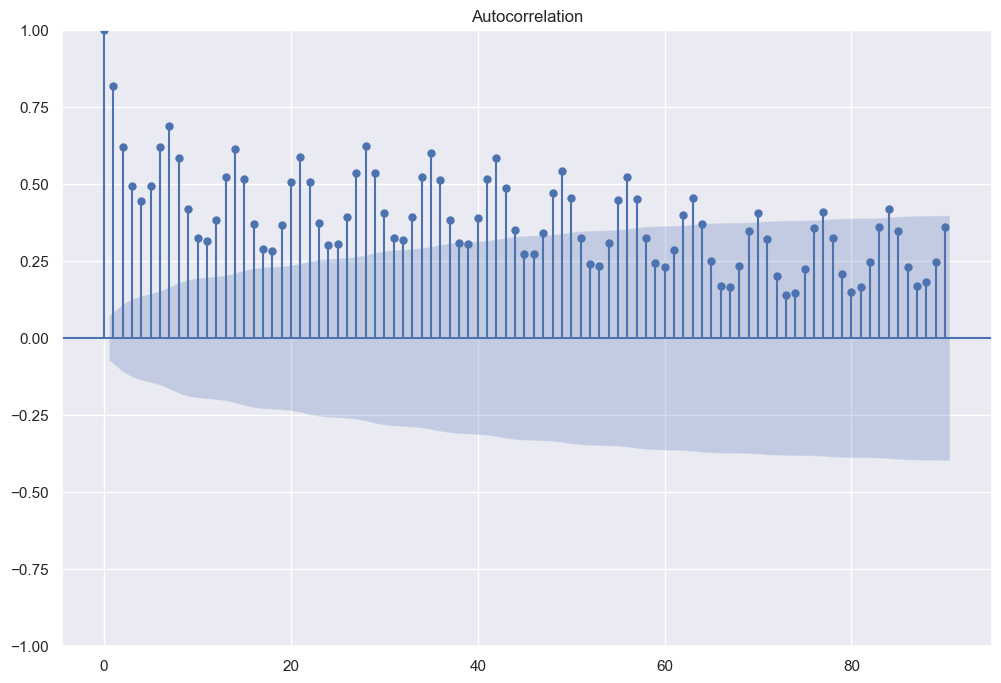

In [24]:
plot_acf(dailyData.yellow[:730], lags = 90); #plot autocorrelations for lags up to 3 months #we see spikes around 7 (1 week), 14 (2 weeks) etc highlighting a weekly period

### Q3, select a proper period from task 2 and build up a linear regression model which takes day count from the beginning (index) and period into account to predict yellow taxi ridership (trend+seasonality) model.

We may add the day of week as categorical variables to represent seasonality in a linear regression model. The same as Q1, using the index as the day's count from the first day represents the trend. Train the model on the first two years of data.

In [25]:
dailyData['DOW'] = pd.to_datetime(dailyData.date).dt.dayofweek #monday = 0, sunday = 6

In [26]:
# train the model over the first 730 days (2 years)
X = pd.concat([pd.DataFrame(range(dailyData.shape[0]),columns=['day']),pd.get_dummies(dailyData['DOW'],drop_first=False)],axis=1)
#X = sm.add_constant(X) #we do not need an intercept as we have an individual constant for each day of the week (drop_first = False)
#alternatively we can add a constant but then exclude a dummy for Monday using drop_first = True - will do so below
lmGreen=sm.OLS(dailyData.green[:730],X[:730]).fit()
print (lmGreen.summary())

                            OLS Regression Results                            
Dep. Variable:                  green   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     465.0
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          1.42e-262
Time:                        15:03:58   Log-Likelihood:                -6628.0
No. Observations:                 730   AIC:                         1.327e+04
Df Residuals:                     722   BIC:                         1.331e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -20.0448      0.375    -53.466      0.0

(25000.0, 30000.0)

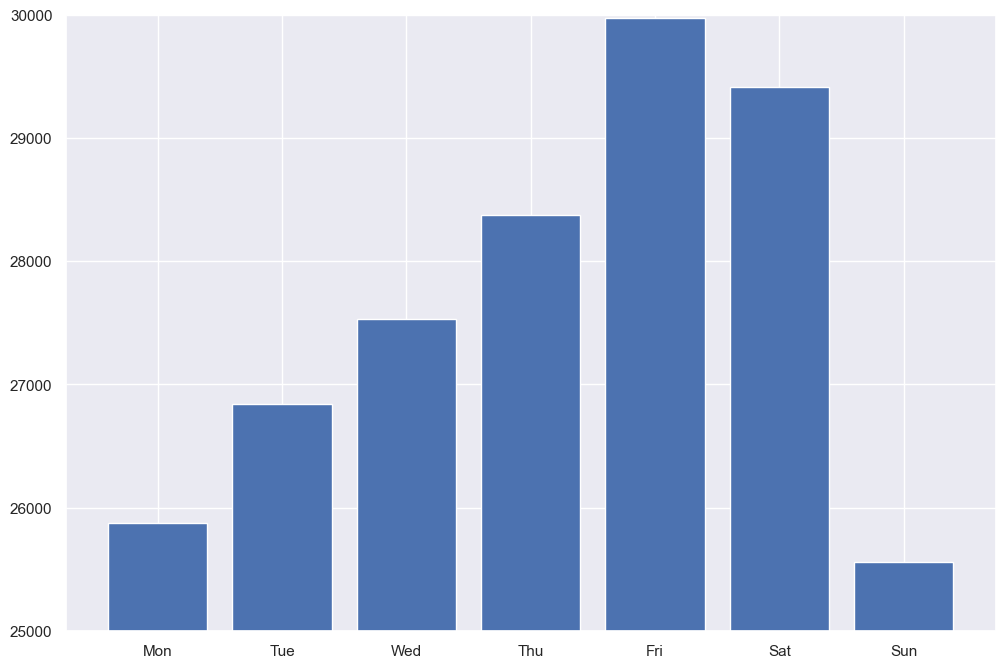

In [27]:
# visualize the effect of each day of week on taxi ridership
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lmGreen.params[1:].tolist())
plt.ylim([25000,30000])

In [28]:
# train the model over the first 730 days (2 years)
X2 = pd.concat([pd.DataFrame(range(dailyData.shape[0]),columns=['day']),pd.get_dummies(dailyData['DOW'],drop_first=True)],axis=1)
X2 = sm.add_constant(X2) #use intercept instead of an exluded dummy for Monday; other dummies will be relative
lmGreen2=sm.OLS(dailyData.green[:730],X2[:730]).fit()
print (lmGreen2.summary())

                            OLS Regression Results                            
Dep. Variable:                  green   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     465.0
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          1.42e-262
Time:                        15:03:59   Log-Likelihood:                -6628.0
No. Observations:                 730   AIC:                         1.327e+04
Df Residuals:                     722   BIC:                         1.331e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.588e+04    249.031    103.908      0.0

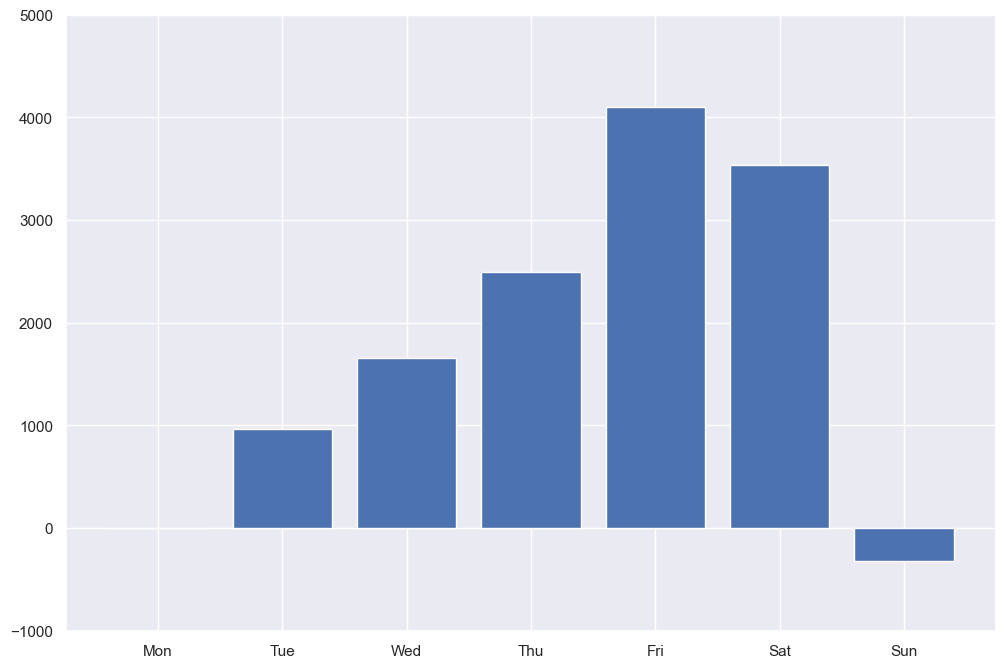

In [29]:
# visualize the effect of each day of week on taxi ridership; relatively Monday
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        [0] + lmGreen2.params[2:].tolist())
plt.ylim([-1000,5000]);
plt.show()

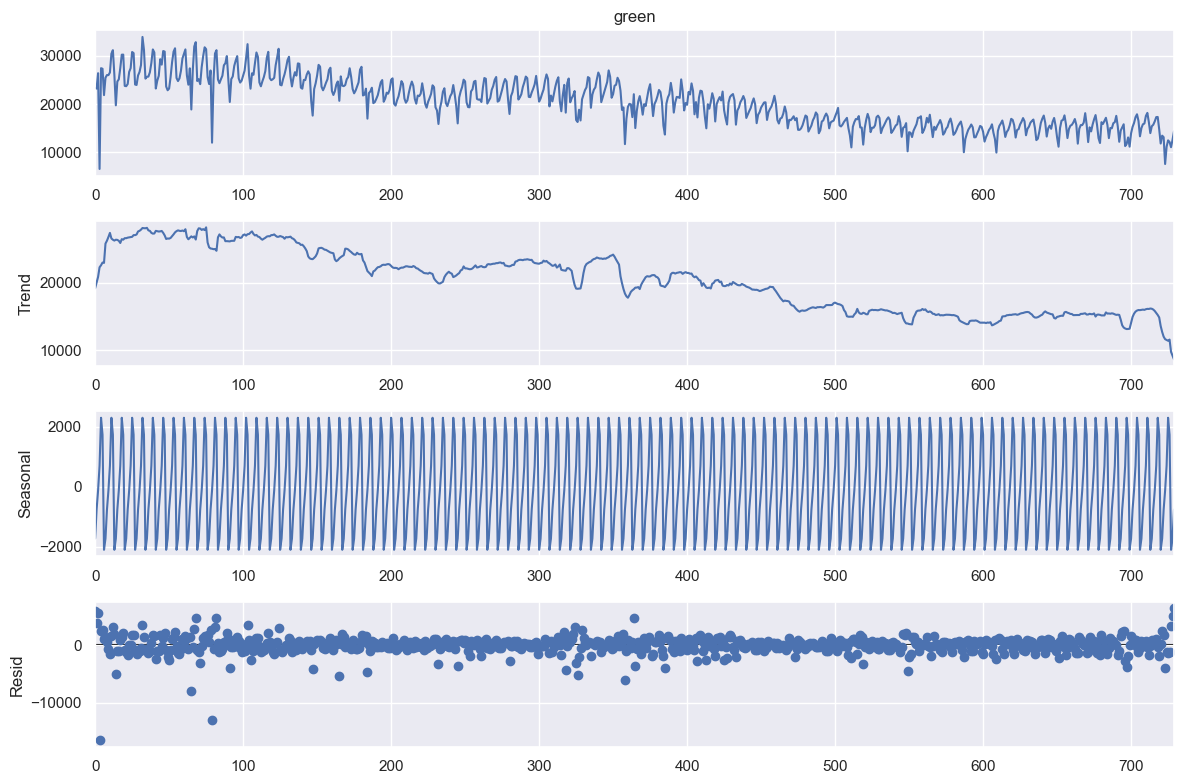

In [30]:
dailyDataBeforeCovid = dailyData.iloc[:730]
dailyDecomp = seasonal_decompose(dailyDataBeforeCovid['green'], model='additive', period = 7, extrapolate_trend='freq')
fig = dailyDecomp.plot()

In [31]:
dailyDataBeforeCovid.head() #see that 2018 start from Monday

,date,yellow,green,DOW
0,2018-01-01,237145.0,23361.0,0
1,2018-01-02,238152.0,23226.0,1
2,2018-01-03,266992.0,26418.0,2
3,2018-01-04,122222.0,6523.0,3
4,2018-01-05,265212.0,27459.0,4


<BarContainer object of 7 artists>

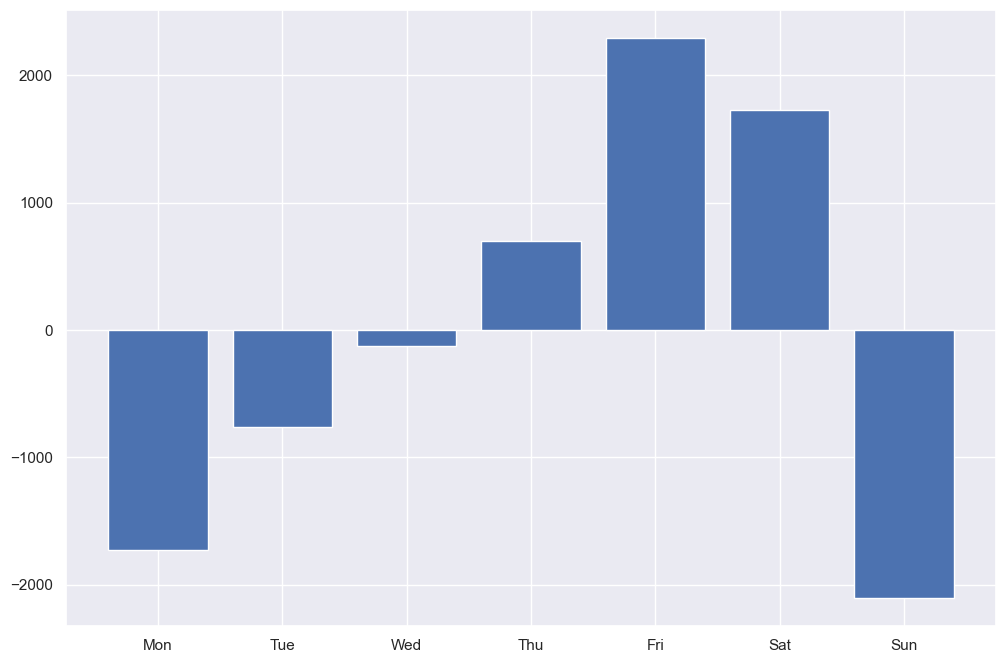

In [32]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],dailyDecomp.seasonal[:7])

In [33]:
# using drop_first=True in pd.get_dummies to aviod redundant columns
# train the model over the first 730 days (2 years)
lmYellow=sm.OLS(dailyData.yellow[:730],X[:730]).fit()
print (lmYellow.summary())

                            OLS Regression Results                            
Dep. Variable:                 yellow   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     136.0
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          2.53e-127
Time:                        15:04:03   Log-Likelihood:                -8530.5
No. Observations:                 730   AIC:                         1.708e+04
Df Residuals:                     722   BIC:                         1.711e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day         -131.5951      5.079    -25.911      0.0

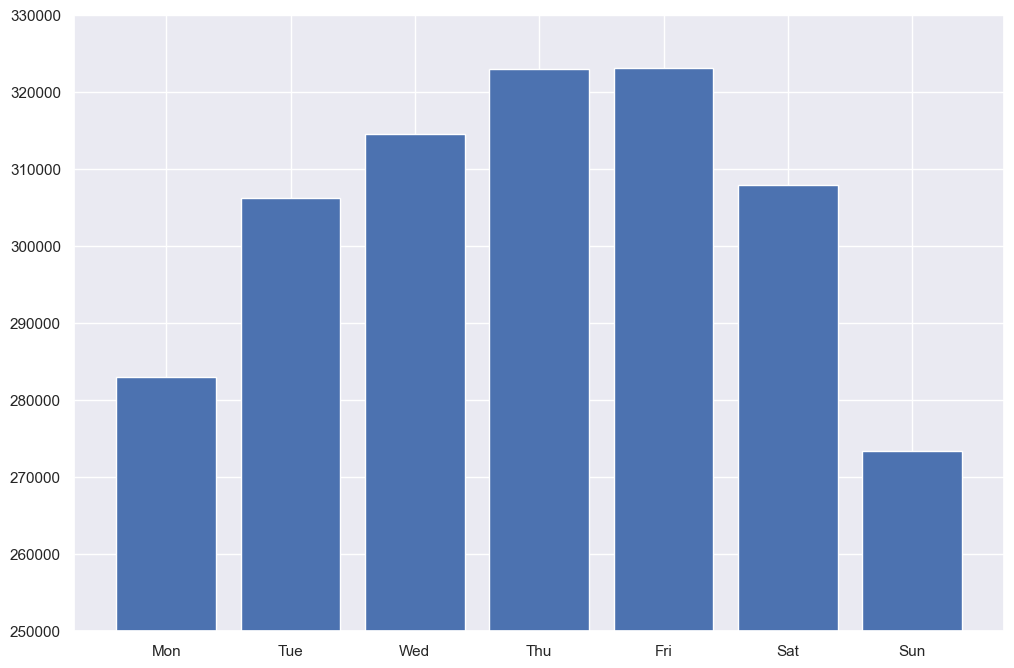

In [34]:
# visualize the effect of each day of week on taxi ridership
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lmYellow.params[1:].tolist())
plt.ylim([2.5e5,3.3e5]);

### Q4, apply the trained model in Q3 to predict green taxi ridership in 2020, and visualize results, and report $R^2$ before and after the shelter-in-place order (March 20).

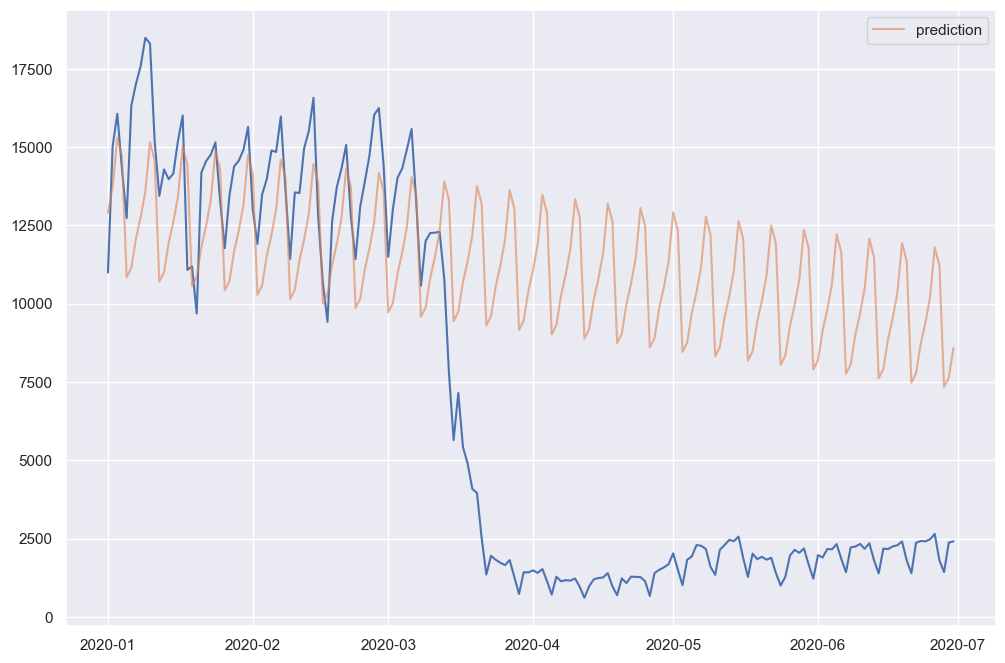

In [35]:
#use the model lmGreen trained over 2018-2019 to predict 2020 ridership
y = lmGreen.predict(X[730:])
#visualize the actual ridership vs the model prediction
plt.plot(dailyData.date[730:],dailyData.green[730:])
plt.plot(dailyData.date[730:],y,label='prediction',alpha=0.6)
plt.legend()

The actual ridership looks generally consistent with the model prediction all the until mid-March 2020, but then starts to deviate significantly.

In [36]:
r2_score(dailyData.green[730:809],y[:79]) #out-of sample r2 of the time-series model before covid lockdown (March,20)

0.11087973091408054

In [37]:
r2_score(dailyData.green[809:],y[79:]) #out-of sample r2 of the time-series model after covid lockdown (March, 20)

-253.088438041758

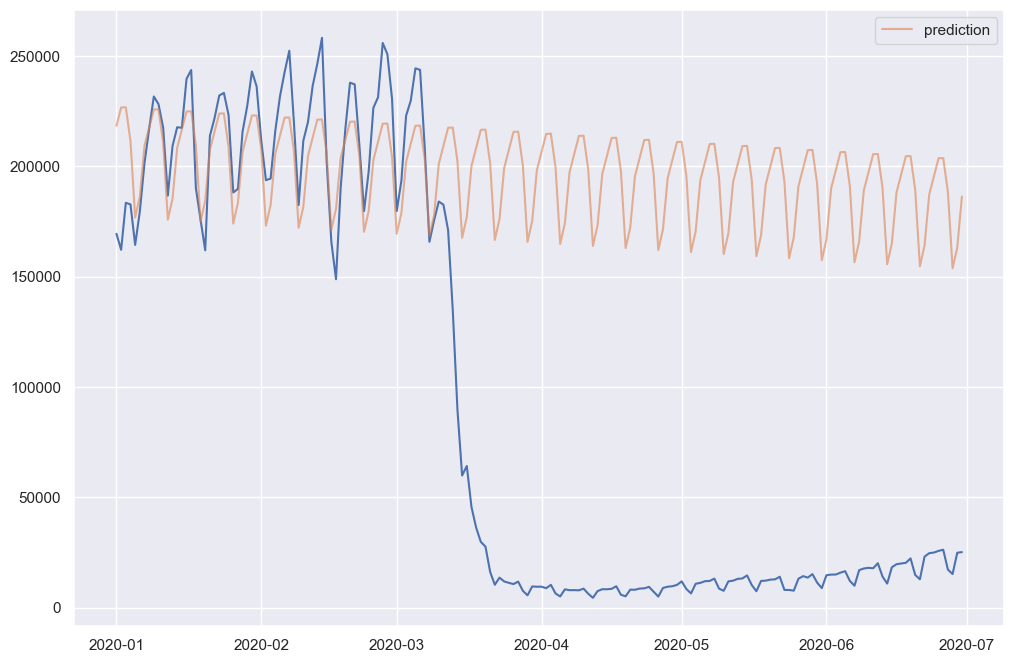

In [38]:
y = lmYellow.predict(X[730:])
plt.plot(dailyData.date[730:],dailyData.yellow[730:])
plt.plot(dailyData.date[730:],y,label='prediction',alpha=0.6)
plt.legend();

In [39]:
r2_score(dailyData.yellow[730:809],y[:79])

0.15408517952254308

In [40]:
r2_score(dailyData.yellow[809:],y[79:])

-1137.032508161575

## 3. Normality Test for the Noise Distribution

Time-series models assume uncertainty through residuals. Most models (including linear regression for trend and seasonality) impose certain statistical assumptions on the residuals first of all, e.g. having them follow normal distribution, in particular that they follow normal distributions with zero mean and that there is no correlation between residuals at different moments of time. 

We shall discuss that in more detail in the following class on time-series models, but for now let's just introduce normality test for the considered case. For that purpose we'll use:

- A Histogram Plot

- Statistical Normality Tests 


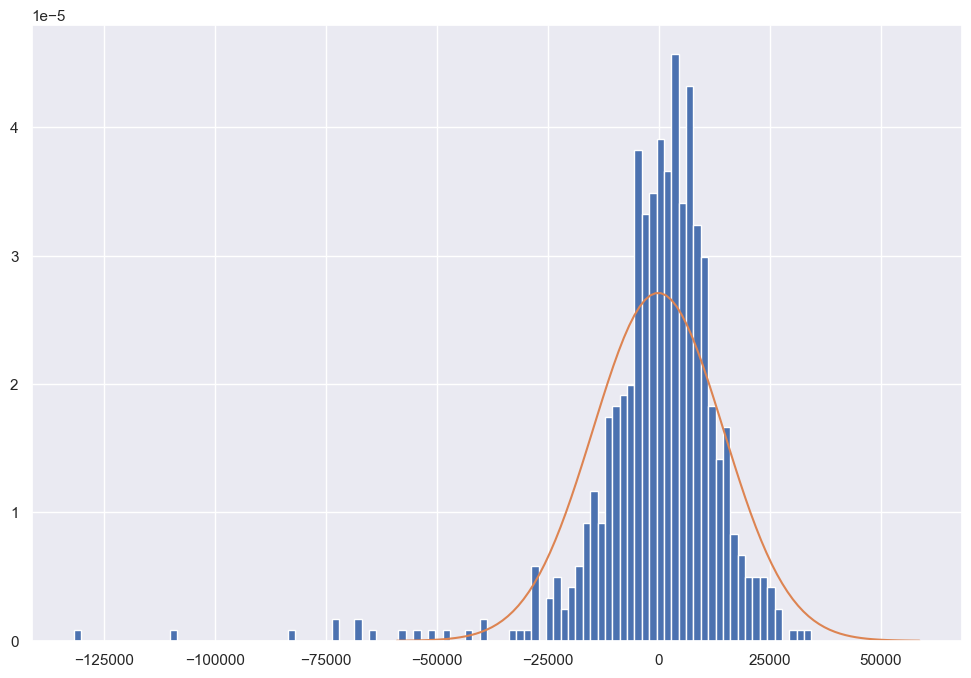

In [41]:
# check the distribution of a sample of data is the histogram
from numpy.random import seed
from numpy.random import randn

# exclude 2020 data to aviod the impact of the pandemic
# sm.tsa.seasonal_decompose: seasonal decomposition using moving averages. 

# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]
# period is from scipy.signal.periodogram

addResult = seasonal_decompose(dailyDataBeforeCovid.yellow, model='additive', period = 7)
residualAdd = np.array(addResult.resid)
residualAdd = residualAdd[np.logical_not(np.isnan(residualAdd))]
# get rid of nan values from the seasonal_decompose
plt.hist(residualAdd,bins=100,density=True)
sigma=residualAdd.std()
x=np.linspace(-4*sigma+residualAdd.mean(),4*sigma+residualAdd.mean(),100)
# seed the random number generator
seed(1)
plt.plot(x,scipy.stats.norm.pdf(x,loc=residualAdd.mean(),scale=sigma))
plt.show()

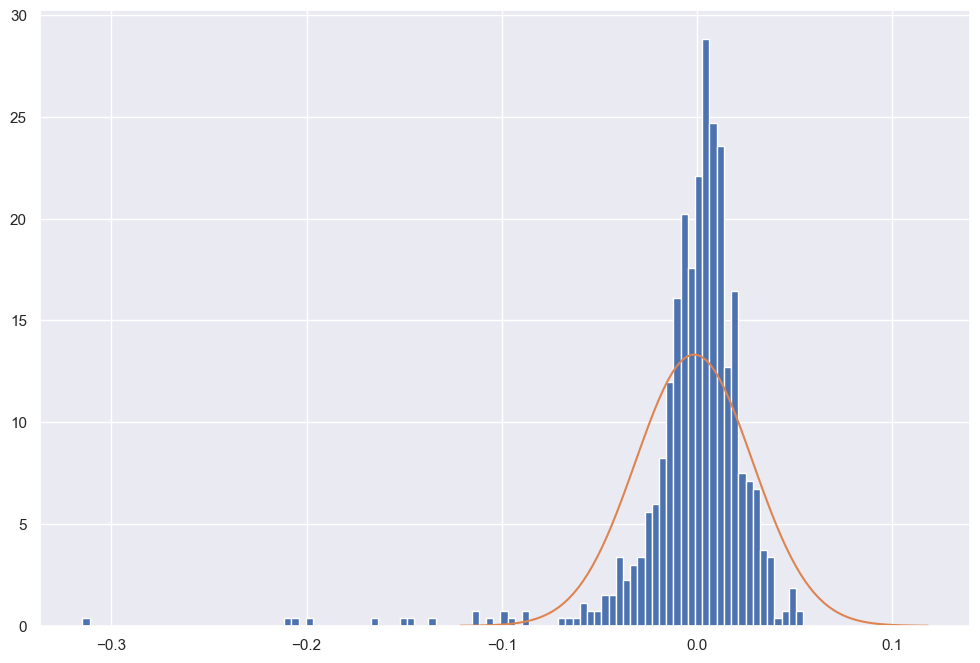

In [42]:
# check the distribution of a sample of data is the histogram
from numpy.random import seed
from numpy.random import randn

# exclude 2020 data to aviod the impact of the pandemic
# sm.tsa.seasonal_decompose: seasonal decomposition using moving averages. 
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]
# period is from scipy.signal.periodogram
multResult = seasonal_decompose(dailyDataBeforeCovid.yellow, model='multiplicative', period = 7)
residualMult = np.log10(np.array(multResult.resid))
residualMult = residualMult[np.logical_not(np.isnan(residualMult))]
# get rid of nan values from the seasonal_decompose
plt.hist(residualMult,bins=100,density=True)
sigma=residualMult.std()
x=np.linspace(-4*sigma+residualMult.mean(),4*sigma+residualMult.mean(),100)
# seed the random number generator
seed(1)
plt.plot(x,scipy.stats.norm.pdf(x,loc=residualMult.mean(),scale=sigma))
plt.show()

Use Kolmogorov-Smirnov test to compare empirical distributions vs the normal

In [43]:
scipy.stats.kstest(residualAdd, 'norm')

KstestResult(statistic=0.5621546961325967, pvalue=2.8388245289944947e-216)

In [44]:
scipy.stats.kstest(residualMult, 'norm')

KstestResult(statistic=0.47833557068652266, pvalue=8.562232486063015e-153)

The p-values are way below 5\% (and even 1\% or 0.1\%), so the normality hypothesis should be rejected at any reasonable significance level (probability of rejecting hypothesis when it'd be actually true).

Introduce a few more statistical test which could be used for the same purpose

**Shapiro-Wilk Test** 
The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.
In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.
The shapiro() SciPy function will calculate the Shapiro-Wilk on a given dataset. The function returns both the W-statistic calculated by the test and the p-value.

**D’Agostino’s K^2 Test**
The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.
The D’Agostino’s K^2 test is available via the normaltest() SciPy function and returns the test statistic and the p-value.

**Anderson-Darling Test**
Anderson-Darling Test is a statistical test that can be used to evaluate whether a data sample comes from one of among many known data samples, named for Theodore Anderson and Donald Darling.

It can be used to check whether a data sample is normal. The test is a modified version of a more sophisticated nonparametric goodness-of-fit statistical test called the Kolmogorov-Smirnov test.

A feature of the Anderson-Darling test is that it returns a list of critical values rather than a single p-value. This can provide the basis for a more thorough interpretation of the result.

The anderson() SciPy function implements the Anderson-Darling test. It takes as parameters the data sample and the name of the distribution to test it against. By default, the test will check against the Gaussian distribution (dist=’norm’).

In [45]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(residualAdd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.812, p=0.000
Sample does not look Gaussian (reject H0)


In [46]:
#for comparison try on the actual normal distribution
seed(1)
stat, p = shapiro(np.random.normal(0,1,size=500)); p

0.753082275390625

In [47]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest
# seed the random number generator
seed(1)
# normality test
stat, p = normaltest(residualAdd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=497.300, p=0.000
Sample does not look Gaussian (reject H0)


In [48]:
# Anderson-Darling Test
from scipy.stats import anderson
# seed the random number generator
seed(1)
# normality test
result = anderson(residualAdd)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 20.210
15.000: 0.573, data does not look normal (reject H0)
10.000: 0.652, data does not look normal (reject H0)
5.000: 0.783, data does not look normal (reject H0)
2.500: 0.913, data does not look normal (reject H0)
1.000: 1.086, data does not look normal (reject H0)


## 4. Outlier Detection on Residual

Time-series residuals could be also used for anomaly detection - identifying the observations that can't be well described by the time-series model, i.e. the moments of time when the difference between the observed time-series value and the model prediction is particularly strong.

We can use multiplicative residuals defined as above for that purpose, taking the top 1\% and bottom 1\% of the residual values as upper (observations are much higher than predicted) and lower (observations are much lower than predicted) anomalies. 

In [49]:
daySeries = dailyDataBeforeCovid['yellow']
dailyDecomp = seasonal_decompose(daySeries, model='multicative', period = 7, extrapolate_trend='freq')
residualMult = np.array(dailyDecomp.resid)
resMult = dailyDecomp.resid
#fig = dailyDecomp.plot();

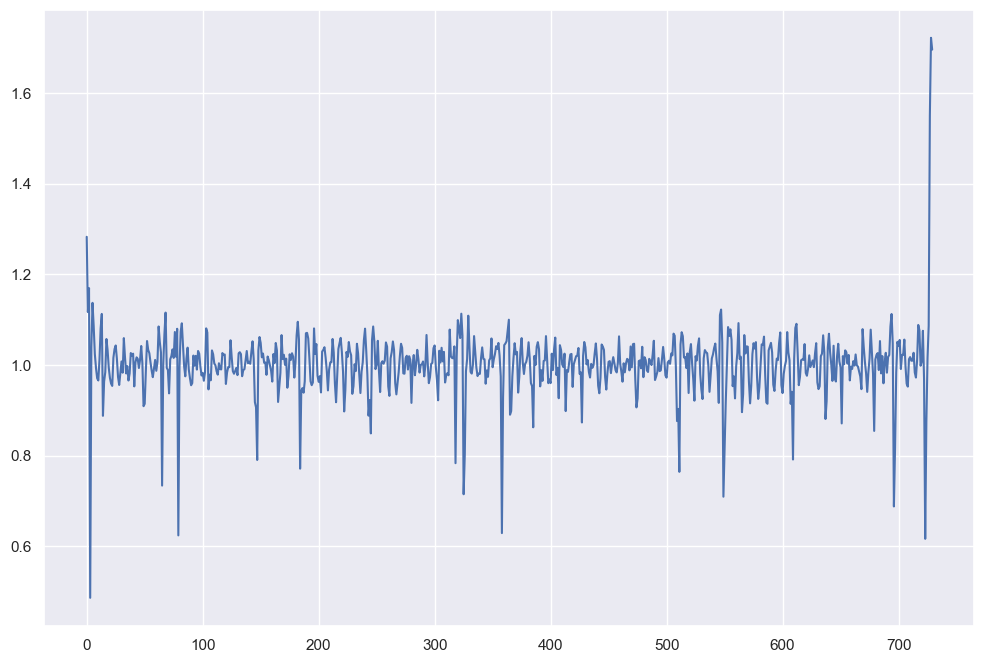

In [50]:
# normalize residual by log-transform
#logResid = np.log(dailyDecomp.resid/daySeries.values)
plt.show()
plt.plot(resMult);

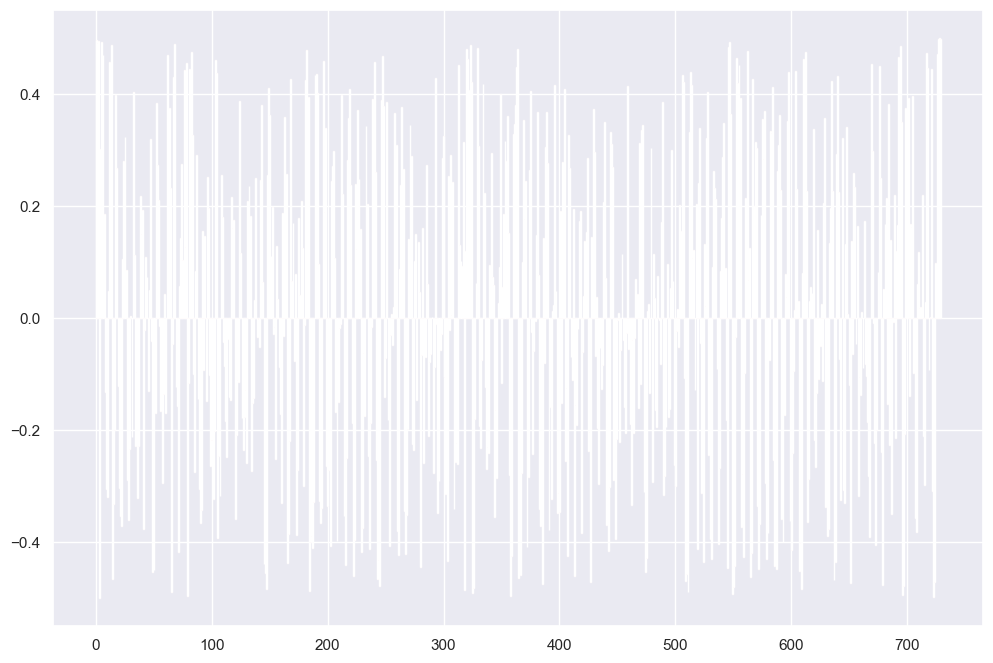

In [51]:
# based on percentile rank

outlierData = pd.DataFrame()
outlierData['Res'] = residualMult
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'], color='red')
plt.show()

In [52]:
# There is no certain definition of outliers, common methods include percentile, standard deviation, and IQR.
# In this case, we select 1% outliers.
dailyDataBeforeCovid.date[outlierData['Percentile_rank']>0.49]

0      2018-01-01
1      2018-01-02
2      2018-01-03
5      2018-01-06
547    2019-07-02
727    2019-12-29
728    2019-12-30
729    2019-12-31
Name: date, dtype: object

In [53]:
#upper 1% outliers correspond to days surrounding the holidays - immediately after New Year 2018 and before and the New Year 2019 also 2 days before July,4, 2019

In [54]:
dailyDataBeforeCovid.date[outlierData['Percentile_rank']<-0.49]

3      2018-01-04
79     2018-03-21
325    2018-11-22
358    2018-12-25
549    2019-07-04
696    2019-11-28
723    2019-12-25
Name: date, dtype: object

In [55]:
#lower 1% outliers correspond to the holidays themselves - two Chrismas Days, two Thankkgiving day, July, 4 and also apparently March, 21, 2018 and January, 4, 2018